In [28]:
using Revise
using Plots
using PlotlyJS
using Statistics
includet("../src/antennaArray.jl")
includet("../src/utils.jl")

N = 10
λ = 1
f = C_LIGHT / λ
δ = 0
precisionStep = 0.1

function meanHeuristic(I)
    antenna = createAntennaArray1D(f, I, 0.5, [0.25, 0.25, 0.25, 0.25, 0.25], N, [0.0, 0.0, 0.0, 0.0, 0.0])
    
    θ = deg2rad.(0:1:70)
    AF = arrayFactor.(Ref(antenna), θ, 0)
    return mean(AF)
end

function maxSLL(AF, print=false)
    local_maxima = findall(x -> x > 0 && AF[x] > AF[x-1] && AF[x] > AF[x+1], 2:length(AF)-1)
    sorted_maxima = sort(AF[local_maxima], rev=true)
    if print
        println(sorted_maxima)
    end
    println(sorted_maxima)
    return length(sorted_maxima) >= 3 ? sorted_maxima[3] : minimum(AF)
end

maxSLL (generic function with 2 methods)

## Parametric Analysis 1
- 4 different A values (4, 8, 16, 24)
- Linear interpolation for intermediate element currents
- No manual tuning of intermediate currents

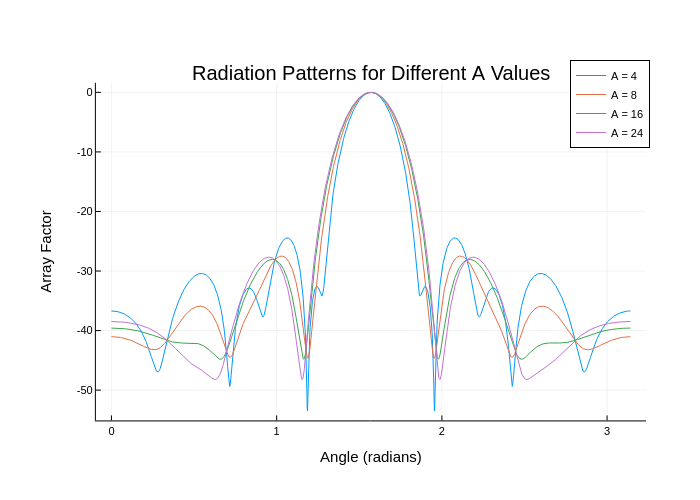

In [27]:
# Max SLL simulation for different A values, without manual tuning 
θ = deg2rad.(vcat(0:precisionStep:180))
plotlyjs()
Plots.plot()
for A in [4, 8, 16, 24]
    I_h = collect(range(1, stop=A, length=Int(N/2)))
    I = vcat(I_h, reverse(I_h))
    antenna = createAntennaArray1D(f, I, 0.5, [0.25, 0.25, 0.25, 0.25, 0.25], N, [0.0, 0.0, 0.0, 0.0, 0.0])
    AF = arrayFactor.(Ref(antenna), θ, 0)
    normAF = abs.(AF) ./ maximum(abs.(AF))
    Plots.plot!(θ, 20log10.(normAF), label="A = $A")
    SLL = maxSLL(normAF)
    println("A: ", A, " Maximum SLL: ", 20log10(SLL), " dB")
end
xlabel!("Angle (radians)")
ylabel!("Array Factor")
title!("Radiation Patterns for Different A Values")

## Parametric Analysis 2
- 4 different A values (4, 8, 16, 24)
- Linear interpolation for intermediate element currents
- With manual tuning of intermediate currents

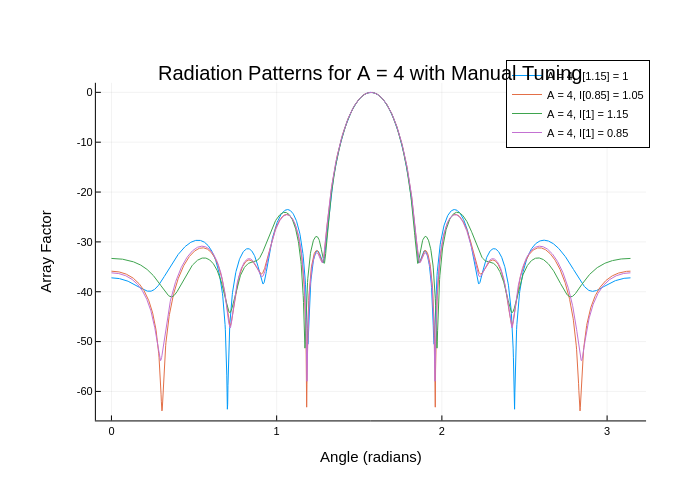

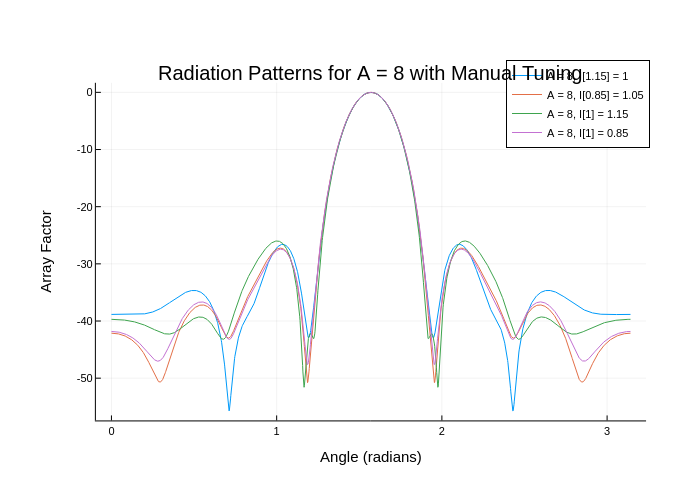

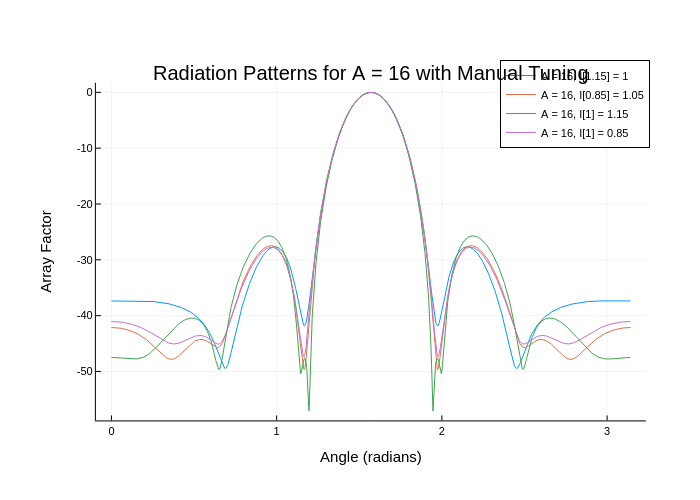

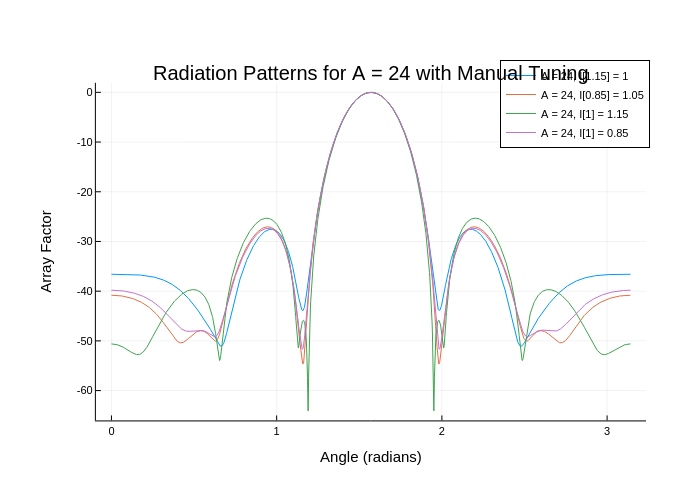

In [26]:
plotlyjs()
θ = deg2rad.(vcat(0:precisionStep:180))
for A in [4, 8, 16, 24]
    p = Plots.plot()
    I_h = collect(range(1, stop=A, length=Int(N/2)))
    for (i, j) in [(1.15, 1), (0.85, 1.05), (1, 1.15), (1, 0.85)]
        I_h[2] = i * I_h[2]
        I_h[4] = j * I_h[4]
        I = vcat(I_h, reverse(I_h))
        antenna = createAntennaArray1D(f, I, 0.5, [0.25, 0.25, 0.25, 0.25, 0.25], N, [0.0, 0.0, 0.0, 0.0, 0.0])
        AF = arrayFactor.(Ref(antenna), θ, 0)
        normAF = abs.(AF) ./ maximum(abs.(AF))
        Plots.plot!(p, θ, 20log10.(normAF), label="A = $A, I[$i] = $j")
        SLL = maxSLL(normAF)
        println("A: ", A, " I[$i]: $j Maximum SLL: ", 20log10(SLL), " dB")
    end
    xlabel!(p, "Angle (radians)")
    ylabel!(p, "Array Factor")
    title!(p, "Radiation Patterns for A = $A with Manual Tuning")
    display(p)
end

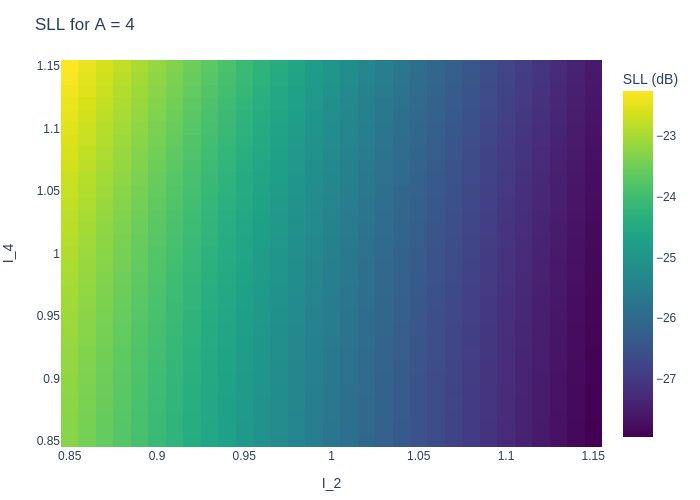

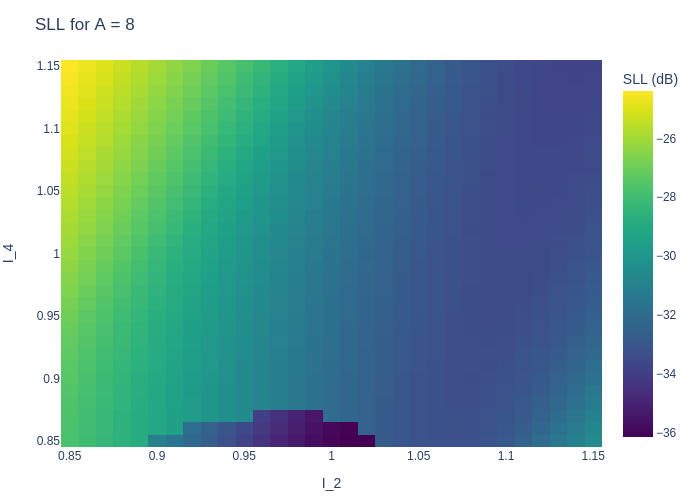

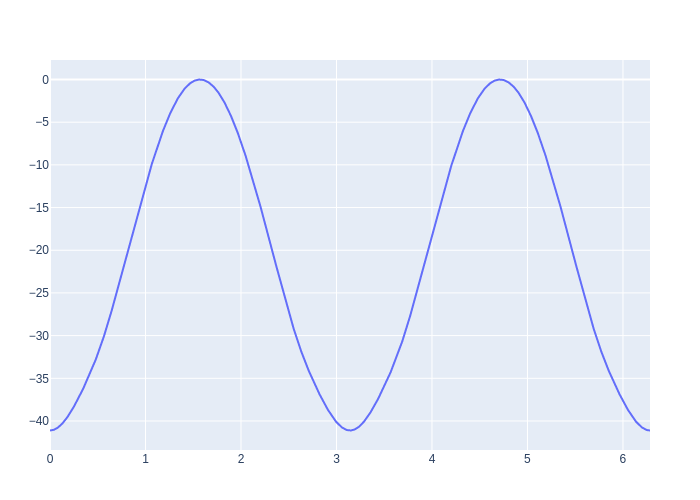

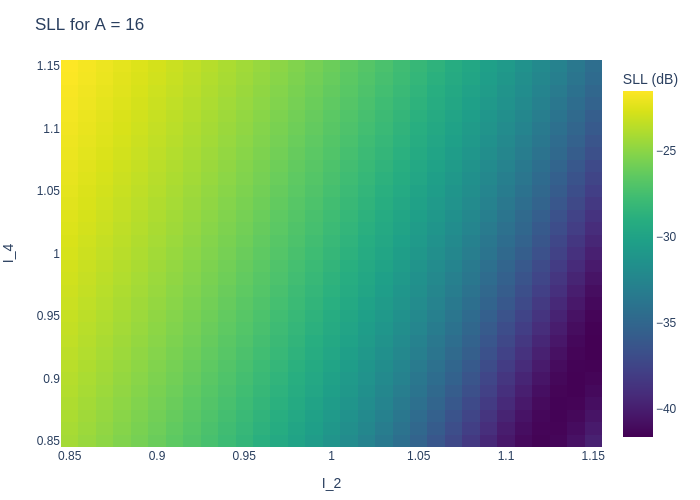

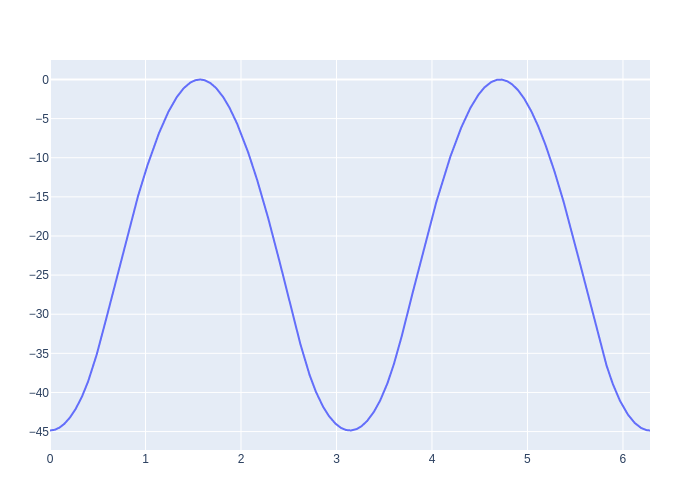

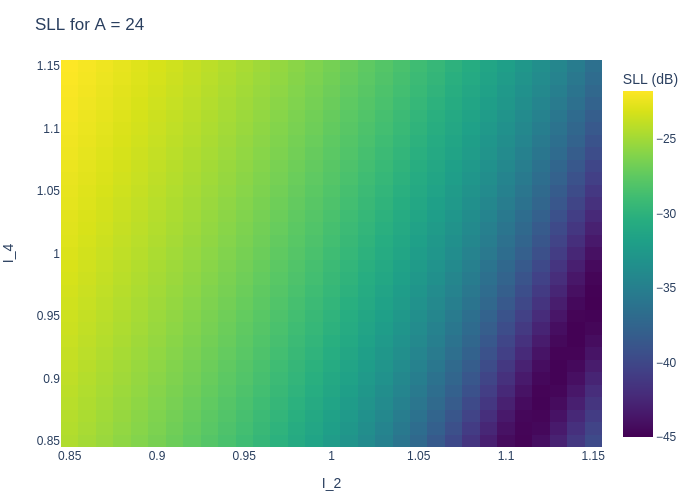

In [44]:
θ = deg2rad.(vcat(0:precisionStep:360))
for A in [4, 8, 16, 24]
    println("A: ", A)
    min = 0.85
    max = 1.15
    step = 0.01
    SLL_size = Int(ceil((max - min) / step + 1))
    SLLs = zeros(SLL_size, SLL_size)
    SLL_I = zeros(SLL_size)
    I_h = collect(range(1, stop=A, length=Int(N/2)))
    Ih2 = I_h[2]
    Ih4 = I_h[4]
    Ih3 = I_h[3]
    for i in enumerate(min:step:max)
        for j in enumerate(min:step:max)
            I_h[2] = i[2] * Ih2
            I_h[4] = j[2] * Ih4
            if A > 10
                I_h[3] = 0.8 * Ih3
            end
            I = vcat(I_h, reverse(I_h))
            antenna = createAntennaArray1D(f, I, 0.5, [0.25, 0.25, 0.25, 0.25, 0.25], N, [0.0, 0.0, 0.0, 0.0, 0.0])
            AF = arrayFactor.(Ref(antenna), θ, 0)
            normAF = 20log10.(abs.(AF) ./ maximum(abs.(AF)))
            
            if A > 10 && i[1] == 4 && j[1] == 28
                p = PlotlyJS.plot(θ, normAF)
                display(p)

                
            end

            SLL = maxSLL(normAF)
            if isnan(SLL)
                @warn "Value is NaN" color=:yellow
                SLLs[i[1], j[1]] = -100
            else
                SLLs[i[1], j[1]] = SLL
                SLL_I[i[1]] = SLL
            end
            println("SLLs[$(i[1]), $(j[1])]: ", SLLs[i[1], j[1]], " dB")
        end
    end
    
    # data = PlotlyJS.contour(;z=SLLs, x=min:step:max, y=min:step:max, colorbar_title="SLL (dB)", colorscale="Viridis")
    # p = PlotlyJS.plot(data)
    # xaxis!(p, "I_2")
    # yaxis!(p, "I_4")
    # # title!(p, "SLL for A = $A")
    # display(p)

    trace = PlotlyJS.heatmap(z=SLLs, x=min:step:max, y=min:step:max, colorbar_title="SLL (dB)", colorscale="Viridis")
    layout = Layout(title="SLL for A = $A", xaxis_title="I_2", yaxis_title="I_4")
    p = PlotlyJS.plot(trace, layout)
    display(p)
    

end

